In [1]:
# https://github.com/a-agmon/anomaly_det/blob/master/AnomalyDetectorsVAE-KDD-original.ipynb
# https://towardsdatascience.com/hands-on-anomaly-detection-with-variational-autoencoders-d4044672acd5

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

2022-03-08 00:36:05.681622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 00:36:05.681642: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [4]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [5]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

In [6]:
# Delete marker column 
#traffic_df.drop(['marker'], axis=1, inplace=True)
#combine_df.drop(['marker'], axis=1, inplace=True)
#attack_df.drop(['marker'], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 129)
combine shape (78377, 129)
attack shape (55663, 129)


In [8]:
combine_df = combine_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(combine_df)

In [9]:
df_scaled.shape

(78377, 129)

In [10]:
labels = combine_labels
norm_samples = df_scaled[labels == 1]  # normal data
attack_samples = df_scaled[labels == 0]  # attack data

norm_labels = labels[labels == 1]
attack_labels = labels[labels == 0]

In [11]:
attack_samples.shape

(22714, 129)

In [12]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.8 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_samples[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [13]:
X_train.shape

(44530, 129)

In [14]:
X_test.shape

(22266, 129)

In [15]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [16]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [17]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)
intermediate_dim = 512
latent_dim = 256

In [18]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 129)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          66560       ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 256)          131328      ['dense[0][0]']                  
                                                                                            

In [19]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 129)               66177     
                                                                 
Total params: 197,761
Trainable params: 197,761
Non-trainable params: 0
_________________________________________________________________


In [20]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [21]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [22]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=1000,
                        batch_size=256)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 129)]             0         
                                                                 
 encoder (Functional)        (None, 256)               329216    
                                                                 
 decoder (Functional)        (None, 129)               197761    
                                                                 
Total params: 526,977
Trainable params: 526,977
Non-trainable params: 0
_________________________________________________________________
Train on 44530 samples
Epoch 1/1000


2022-03-08 00:36:11.265653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 00:36:11.266421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 00:36:11.266547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-08 00:36:11.266662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-08 00:36:11.269479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

44530/44530 [==============================] - 2s 56us/sample - loss: 1364.6153
Epoch 2/1000
44530/44530 [==============================] - 2s 40us/sample - loss: 428.5738
Epoch 3/1000
44530/44530 [==============================] - 2s 40us/sample - loss: 284.4959
Epoch 4/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 226.0165
Epoch 5/1000
44530/44530 [==============================] - 2s 40us/sample - loss: 195.5176
Epoch 6/1000
44530/44530 [==============================] - 2s 39us/sample - loss: 175.2063
Epoch 7/1000
44530/44530 [==============================] - 2s 39us/sample - loss: 159.4491
Epoch 8/1000
44530/44530 [==============================] - 2s 39us/sample - loss: 146.1096
Epoch 9/1000
44530/44530 [==============================] - 2s 39us/sample - loss: 135.9397
Epoch 10/1000
44530/44530 [==============================] - 2s 39us/sample - loss: 127.5889
Epoch 11/1000
44530/44530 [==============================] - 2s 39us/sample - loss: 121.079

44530/44530 [==============================] - 2s 41us/sample - loss: 30.8290
Epoch 91/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 30.6259
Epoch 92/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 30.2797
Epoch 93/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 30.0296
Epoch 94/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 29.8734
Epoch 95/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 29.5271
Epoch 96/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 29.3910
Epoch 97/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 29.0088
Epoch 98/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 28.9325
Epoch 99/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 28.5554
Epoch 100/1000
44530/44530 [==============================] - 2s 41us/sample - loss: 28.5083
E

44530/44530 [==============================] - 2s 42us/sample - loss: 19.0773
Epoch 179/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 19.0359
Epoch 180/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 19.0829
Epoch 181/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 18.9415
Epoch 182/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 18.8194
Epoch 183/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 18.8298
Epoch 184/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 18.8074
Epoch 185/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 18.6017
Epoch 186/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 18.5499
Epoch 187/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 18.5486
Epoch 188/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 

44530/44530 [==============================] - 2s 43us/sample - loss: 14.5676
Epoch 267/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 14.6238
Epoch 268/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 14.5732
Epoch 269/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 14.4054
Epoch 270/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 14.4461
Epoch 271/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 14.4287
Epoch 272/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 14.3946
Epoch 273/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 14.3589
Epoch 274/1000
44530/44530 [==============================] - 2s 42us/sample - loss: 14.3091
Epoch 275/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 14.3179
Epoch 276/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 

44530/44530 [==============================] - 2s 43us/sample - loss: 12.2699
Epoch 355/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.1280
Epoch 356/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.1866
Epoch 357/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.1183
Epoch 358/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.1545
Epoch 359/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.0699
Epoch 360/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 11.9999
Epoch 361/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.0162
Epoch 362/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.0267
Epoch 363/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 12.0019
Epoch 364/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 

44530/44530 [==============================] - 2s 43us/sample - loss: 10.7043
Epoch 443/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 10.6228
Epoch 444/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.6248
Epoch 445/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.6394
Epoch 446/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.5711
Epoch 447/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.5633
Epoch 448/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.6152
Epoch 449/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.6653
Epoch 450/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.4317
Epoch 451/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 10.5815
Epoch 452/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 

44530/44530 [==============================] - 2s 43us/sample - loss: 9.6205
Epoch 531/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.6587
Epoch 532/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.6741
Epoch 533/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.6703
Epoch 534/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.6454
Epoch 535/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.6226
Epoch 536/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.6065
Epoch 537/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.6079
Epoch 538/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.6087
Epoch 539/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.5924
Epoch 540/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.5469
Epo

44530/44530 [==============================] - 2s 44us/sample - loss: 9.5108
Epoch 620/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.4213
Epoch 621/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4029
Epoch 622/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.4670
Epoch 623/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4808
Epoch 624/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.5223
Epoch 625/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.3894
Epoch 626/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5461
Epoch 627/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4765
Epoch 628/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5260
Epoch 629/1000
44530/44530 [==============================] - 2s 43us/sample - loss: 9.4530
Epo

44530/44530 [==============================] - 2s 44us/sample - loss: 9.4169
Epoch 708/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4271
Epoch 709/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4284
Epoch 710/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.3710
Epoch 711/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.3570
Epoch 712/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.3113
Epoch 713/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4477
Epoch 714/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5251
Epoch 715/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4186
Epoch 716/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4065
Epoch 717/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4235
Epo

44530/44530 [==============================] - 2s 44us/sample - loss: 9.5281
Epoch 797/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5869
Epoch 798/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5869
Epoch 799/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5480
Epoch 800/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5302
Epoch 801/1000
44530/44530 [==============================] - 2s 45us/sample - loss: 9.5031
Epoch 802/1000
44530/44530 [==============================] - 2s 45us/sample - loss: 9.5915
Epoch 803/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5352
Epoch 804/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4085
Epoch 805/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.5749
Epoch 806/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.4523
Epo

44530/44530 [==============================] - 2s 44us/sample - loss: 9.1103
Epoch 886/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.0948
Epoch 887/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1696
Epoch 888/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1072
Epoch 889/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1192
Epoch 890/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1714
Epoch 891/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1580
Epoch 892/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1953
Epoch 893/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1365
Epoch 894/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.0747
Epoch 895/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 9.1145
Epo

44530/44530 [==============================] - 2s 44us/sample - loss: 8.8838
Epoch 975/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.7055
Epoch 976/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.6363
Epoch 977/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.6234
Epoch 978/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.6478
Epoch 979/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.6413
Epoch 980/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.5906
Epoch 981/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.6844
Epoch 982/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.5732
Epoch 983/1000
44530/44530 [==============================] - 2s 44us/sample - loss: 8.6355
Epoch 984/1000
44530/44530 [==============================] - 2s 45us/sample - loss: 8.5822
Epo

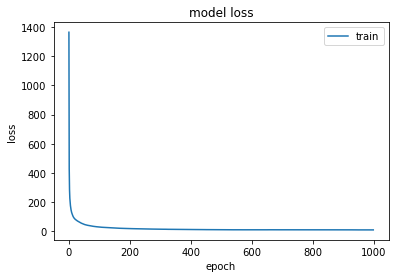

In [23]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [24]:
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [83]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)
error_thresh = np.quantile(mae_vector, 0.98)
print(error_thresh)

Avg error 0.007558072569155209
median error 0.006296536590926029
99Q: 0.025337453547070843
setting threshold on 0.025337453547070843 
0.021712146496430502


In [84]:
X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total anomalies',len(anomalies))
print(np.count_nonzero(anomalies))

print('total y_test',len(y_test))
print(np.count_nonzero(y_test))

total anomalies 22266
11427
total y_test 22266
11133


In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     11133
         1.0       0.97      1.00      0.99     11133

    accuracy                           0.99     22266
   macro avg       0.99      0.99      0.99     22266
weighted avg       0.99      0.99      0.99     22266



In [86]:
X_pred.shape

(22266, 129)

In [87]:
X_encoded = encoder.predict(X_test)

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

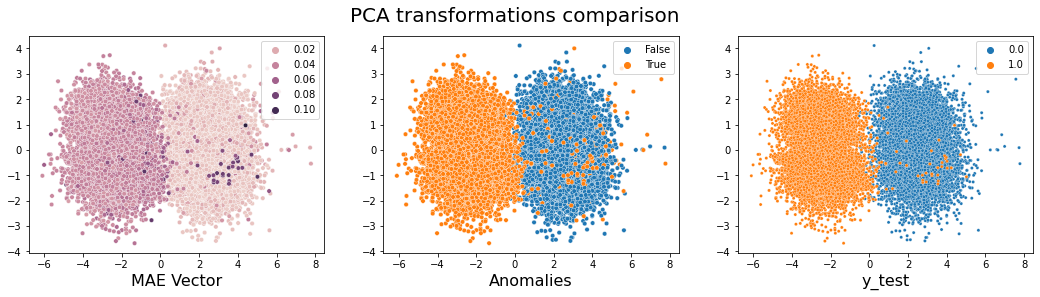

In [89]:
# comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
plt.show()

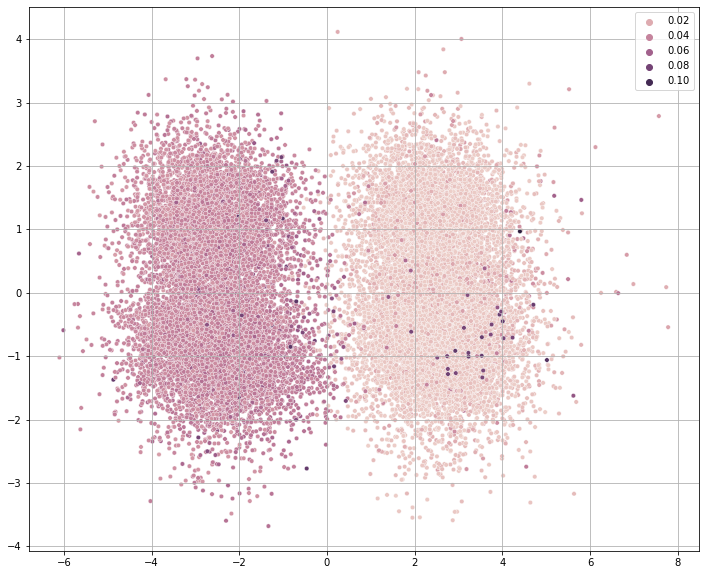

In [90]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

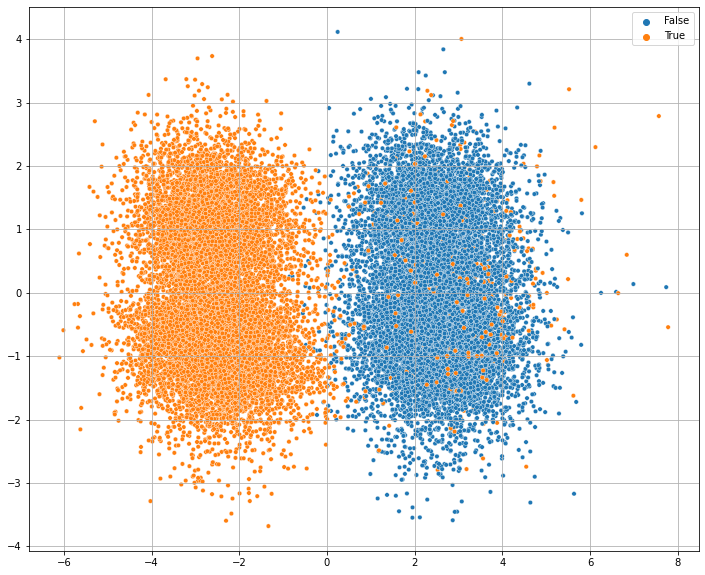

In [91]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

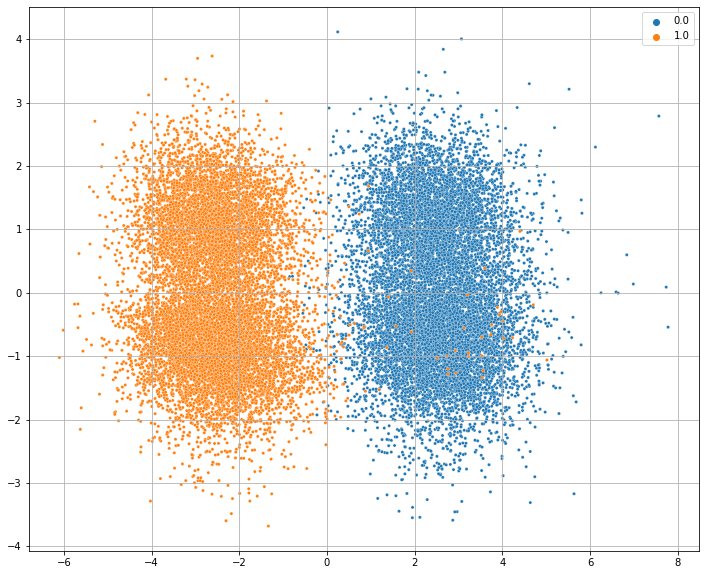

In [92]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In [93]:
X_pred.shape

(22266, 129)

0.021712146496430502


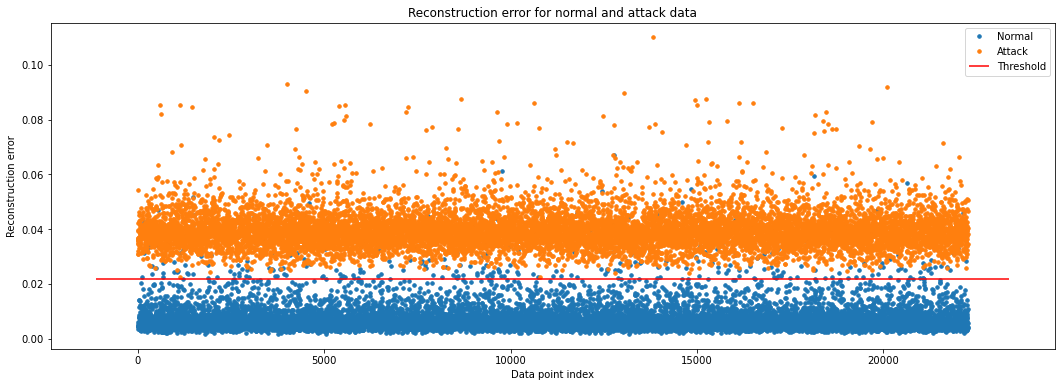

In [94]:
# figure
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
print(error_thresh)
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()